# Learn to execute

``` bash

Input: "535+61" Output: "596"

```

Inspired by learn to fizzbuzz: http://joelgrus.com/2016/05/23/fizz-buzz-in-tensorflow/



In [14]:
from __future__ import print_function
from keras.models import Sequential
from keras.engine.training import slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent
import numpy as np
from six.moves import range

In [15]:
class CharacterTable(object):
    '''
    Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    '''
    def __init__(self, chars, maxlen):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.maxlen = maxlen

    def encode(self, C, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        X = np.zeros((maxlen, len(self.chars)))
        for i, c in enumerate(C):
            X[i, self.char_indices[c]] = 1
        return X

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in X)

In [16]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [17]:
# Parameters for the model and dataset
TRAINING_SIZE = 50000
DIGITS = 3
INVERT = False
# Try replacing GRU, or SimpleRNN
RNN = recurrent.GRU
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1
MAXLEN = DIGITS + 1 + DIGITS

chars = '0123456789+ '
ctable = CharacterTable(chars, MAXLEN)

questions = []
expected = []
seen = set()

In [18]:
%%time

#Generating random  numbers to perofrm addition on
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that X+Y == Y+X (hence the sorting)
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1
    ans += ' ' * (DIGITS + 1 - len(ans))
    if INVERT:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

#We now have 50000 examples of addition, each exaple contains the addition between two numbers
#Each example contains the first number followed by '+' operand followed by the second number 
#examples - 85+96, 353+551, 6+936
#The answers to the additon operation are stored in expected

Generating data...
Total addition questions: 50000
CPU times: user 4.62 s, sys: 36.2 ms, total: 4.66 s
Wall time: 4.67 s


In [19]:
print(len(questions), len(expected))
print(questions[0], expected[0])

50000 50000
503+8   511 


In [20]:
%%time

#The above questions and answers are going to be one hot encoded, 
#before training.
#The encoded values will be used to train the model
#The maximum length of a question can be 7 
#(3 digits followed by '+' followed by 3 digits)
#The maximum length of an answer can be 4 
#(Since the addition of 3 digits yields either a 3 digit number or a 4
#4 digit number)

#Now for training each number or operand is going to be one hot encode below
#In one hot encode there are 12 possibilities '0123456789+ ' (The last one is a space)
#Since we assume a maximum of 3 digit numbers, a two digit number is taken as space with two digts, or 
#a single digit number as two spaces with a number

#So for questions we get 7 rows since the max possible length is 7, and each row has a length of 12 because it will
#be one hot encoded with True and False, depending on the character(any one of the number, '+' operand, or space)
#will be stored  in X_train and X_val
#The 4th position in(1,2,3,4,5,6,7) will indicate the one hot encoding of the '+' operand

##So for questions we get 4 rows since the max possible length is 4, and each row has a length of 12 because it will
#be one hot encoded with True and False, depending on the character(any one of the number, '+' operand, or space)
#will be stored  in y_train and y_val


print('Vectorization...')
X = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    X[i] = ctable.encode(sentence, maxlen=MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, maxlen=DIGITS + 1)

# Shuffle (X, y) in unison as the later parts of X will almost all be larger digits
indices = np.arange(len(y))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over
split_at = len(X) - len(X) / 10
(X_train, X_val) = (slice_X(X, 0, split_at), slice_X(X, split_at))
(y_train, y_val) = (y[:split_at], y[split_at:])

Vectorization...
CPU times: user 337 ms, sys: 9.56 ms, total: 346 ms
Wall time: 350 ms


In [21]:
print(X.shape, y.shape)

(50000, 7, 12) (50000, 4, 12)


In [22]:
print(X[0])
print
print(y[0])

[[False False False False False False  True False False False False False]
 [False False False False False False False False  True False False False]
 [False  True False False False False False False False False False False]
 [False False False False False  True False False False False False False]
 [False False False False False False False  True False False False False]
 [False False False False False False False False False False False  True]
 [ True False False False False False False False False False False False]]
[[False False False False False False  True False False False False False]
 [False False  True False False False False False False False False False]
 [False False False False False False False  True False False False False]
 [ True False False False False False False False False False False False]]


In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(45000, 7, 12)
(45000, 4, 12)
(5000, 7, 12)
(5000, 4, 12)


In [24]:
%%time

#Training the model with the encoded inputs
print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
# note: in a situation where your input sequences have a variable length,
# use input_shape=(None, nb_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# For the decoder's input, we repeat the encoded input for each time step
model.add(RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# For each of step of the output sequence, decide which character should be chosen
model.add(TimeDistributed(Dense(len(chars))))
model.add(Activation('softmax'))

Build model...
CPU times: user 120 ms, sys: 33.6 ms, total: 154 ms
Wall time: 164 ms


In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, RemoteMonitor

remote = RemoteMonitor(root='http://localhost:9000')

In [26]:
# compile and run
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

result = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          nb_epoch=124,
          validation_data=(X_val, y_val),
          verbose=2,
          callbacks = [
                         EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
                         ModelCheckpoint('{}-progress-dl'.format("learn-to-execute"), monitor='val_loss', verbose=True, save_best_only=True), remote],
         )

Train on 45000 samples, validate on 5000 samples
Epoch 1/124
Epoch 00000: val_loss improved from inf to 1.79681, saving model to learn-to-execute-progress-dl
13s - loss: 1.8327 - acc: 0.3403 - val_loss: 1.7968 - val_acc: 0.3482
Epoch 2/124
Epoch 00001: val_loss improved from 1.79681 to 1.46504, saving model to learn-to-execute-progress-dl
13s - loss: 1.5827 - acc: 0.4130 - val_loss: 1.4650 - val_acc: 0.4511
Epoch 3/124
Epoch 00002: val_loss improved from 1.46504 to 1.29585, saving model to learn-to-execute-progress-dl
13s - loss: 1.3693 - acc: 0.4862 - val_loss: 1.2959 - val_acc: 0.5150
Epoch 4/124
Epoch 00003: val_loss improved from 1.29585 to 1.12576, saving model to learn-to-execute-progress-dl
14s - loss: 1.2009 - acc: 0.5486 - val_loss: 1.1258 - val_acc: 0.5745
Epoch 5/124
Epoch 00004: val_loss improved from 1.12576 to 0.99550, saving model to learn-to-execute-progress-dl
14s - loss: 1.0570 - acc: 0.6034 - val_loss: 0.9955 - val_acc: 0.6305
Epoch 6/124
Epoch 00005: val_loss improv

In [27]:
nb_end_epoch = len(result.history['acc'])
print("End at {} epoch".format(nb_end_epoch))

End at 99 epoch


In [28]:
TARGET_NAME = "learn-to-execute"

In [29]:
from sklearn import metrics
from keras.utils import np_utils

In [30]:
# -- load in best network
model.load_weights('{}-progress-dl'.format(TARGET_NAME))
score = model.evaluate(X_val, y_val, verbose=0)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])



Test score: 0.0167780931439
Test accuracy: 0.99485


In [31]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
%matplotlib inline
plt.style.use("ggplot")

from IPython.display import SVG, display
from keras.utils.visualize_util import model_to_dot, plot

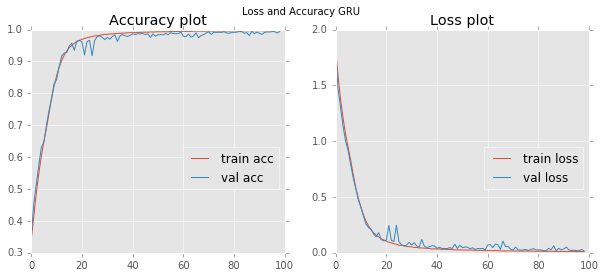

In [32]:
x = range(nb_end_epoch)
fix, ax = plt.subplots(figsize=(10, 4))
plt.suptitle('Loss and Accuracy GRU')
plt.subplot(1, 2, 1)
plt.plot(x, result.history['acc'], label="train acc")
plt.plot(x, result.history['val_acc'], label="val acc")
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.title("Accuracy plot");
plt.subplot(1, 2, 2)
plt.plot(x, result.history['loss'], label="train loss")
plt.plot(x, result.history['val_loss'], label="val loss")
plt.legend(loc='best', bbox_to_anchor=(1,0.5))
plt.title("Loss plot");
plt.show()

In [33]:
import h5py
import json
from keras.models import model_from_json, load_model

In [34]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
gru_3 (GRU)                      (None, 128)           54144       gru_input_2[0][0]                
____________________________________________________________________________________________________
repeatvector_2 (RepeatVector)    (None, 4, 128)        0           gru_3[0][0]                      
____________________________________________________________________________________________________
gru_4 (GRU)                      (None, 4, 128)        98688       repeatvector_2[0][0]             
____________________________________________________________________________________________________
timedistributed_2 (TimeDistribute(None, 4, 12)         1548        gru_4[0][0]                      
___________________________________________________________________________________________

In [35]:
model.save("./{}.h5".format(TARGET_NAME))

# Sanity check

In [36]:
%%time

#For predicting the outputs, the predict method will return 
#an one hot encoded ouput, we decode the one hot encoded 
#ouptut to get our final output

# Select 10 samples from the validation set at random so we can visualize errors
for i in range(10):
    ind = np.random.randint(0, len(X_val))
    rowX, rowy = X_val[np.array([ind])], y_val[np.array([ind])]
    preds = model.predict_classes(rowX, verbose=0)
    q = ctable.decode(rowX[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    print('Q', q[::-1] if INVERT else q)
    print('T', correct)
    print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)
    print('---')

Q 85+442 
T 527 
☑ 527 
---
Q 940+0  
T 940 
☑ 940 
---
Q 816+5  
T 821 
☑ 821 
---
Q 66+506 
T 572 
☑ 572 
---
Q 859+434
T 1293
☑ 1293
---
Q 99+916 
T 1015
☑ 1015
---
Q 720+9  
T 729 
☑ 729 
---
Q 152+7  
T 159 
☑ 159 
---
Q 542+85 
T 627 
☑ 627 
---
Q 8+454  
T 462 
☑ 462 
---
CPU times: user 1.53 s, sys: 403 ms, total: 1.94 s
Wall time: 1.97 s


In [37]:
# kindergarten
q='1+1'
a='2'

# primary school
q='23+75'
a='98'

# high school
q='127+249'
a='376'

# university
q='123+897'
a='1020'

xq = ctable.encode("{:7s}".format(q), maxlen=MAXLEN)
xa = ctable.encode("{:4s}".format(a), maxlen=MAXLEN+1)

preds = model.predict_classes(np.asarray([xq]), verbose=0)
guess = ctable.decode(preds[0], calc_argmax=False)
print('Q', q)
print('T', a)
print(colors.ok + '☑' + colors.close if a.strip() == guess.strip() else colors.fail + '☒' + colors.close, guess)
print('---')

Q 123+897
T 1020
☑ 1020
---


In [ ]:
import re

def fix_math(q, model=model):
    xq = re.findall(r'\d+\+\d+', q)
    if xq:
        xq = xq[0]
        xq = ctable.encode("{:7s}".format(q), maxlen=MAXLEN)
        preds = model.predict_classes(np.asarray([xq]), verbose=0)
        guess = ctable.decode(preds[0], calc_argmax=False)
        return u"👻 \033[35mI guess: " + guess.strip() + "\033[0m"
    else:
        return u"👻 \033[91mGive me correct summation, LOL!!!\033[0m"

In [ ]:
print(fix_math("12+23"))

In [ ]:
print(fix_math(""))